In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6663794340910735
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6628753520824291
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.6628753520824291
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.6628753520824291
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6628753520824291


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

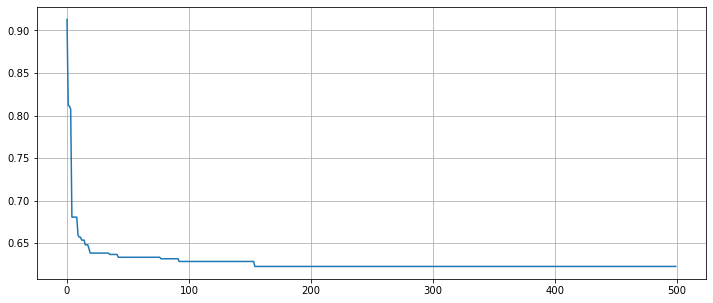

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.87042576]
 [0.09315385]
 [0.03642049]]
[1. 0. 0.] <-> [[0.8749576 ]
 [0.09020787]
 [0.03483447]]
[1. 0. 0.] <-> [[0.8944013 ]
 [0.07731988]
 [0.02827881]]
[0. 0. 1.] <-> [[0.90066314]
 [0.07302905]
 [0.02630783]]
[1. 0. 0.] <-> [[0.794648  ]
 [0.14075546]
 [0.0645966 ]]
[1. 0. 0.] <-> [[0.79231304]
 [0.14217506]
 [0.06551192]]
[1. 0. 0.] <-> [[0.84921324]
 [0.10677159]
 [0.04401513]]
[1. 0. 0.] <-> [[0.7371948 ]
 [0.17473857]
 [0.08806664]]
[0. 1. 0.] <-> [[0.8748511 ]
 [0.09027731]
 [0.03487158]]
[1. 0. 0.] <-> [[0.89339125]
 [0.07800356]
 [0.02860519]]
[1. 0. 0.] <-> [[0.8807951 ]
 [0.08638757]
 [0.03281734]]
[1. 0. 0.] <-> [[0.5455042 ]
 [0.2705741 ]
 [0.18392166]]
[1. 0. 0.] <-> [[0.90608025]
 [0.069226  ]
 [0.02469378]]
[0. 1. 0.] <-> [[0.77958477]
 [0.1498593 ]
 [0.070556  ]]
[1. 0. 0.] <-> [[0.88262796]
 [0.08518099]
 [0.03219106]]
[0. 1. 0.] <-> [[0.8007909 ]
 [0.13700622]
 [0.06220287]]
[1. 0. 0.] <-> [[0.87568164]
 [0.08973568]
 [0.03458259]]
[1. 0. 0.] <->

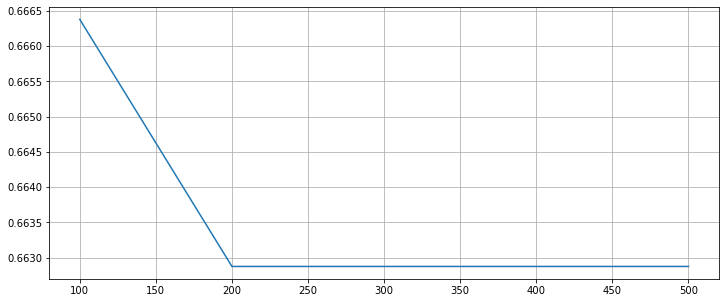

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

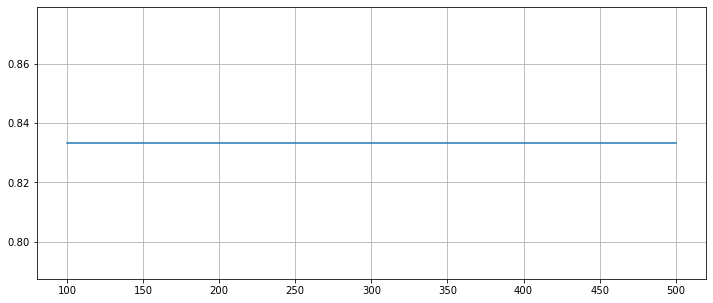

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.4649726 ]
 [ 1.2247794 ]
 [-0.59835637]
 [ 1.1944311 ]
 [-0.7836058 ]]
 bias: [-1.3713918]

Neuron 1: weights:
[[ 3.        ]
 [-1.4953126 ]
 [-0.86750877]
 [ 1.1871493 ]
 [-0.9092077 ]]
 bias: [-2.0186763]

Neuron 2: weights:
[[ 0.6492791 ]
 [-1.6712817 ]
 [-2.9521875 ]
 [ 1.0591718 ]
 [-0.05416107]]
 bias: [0.64398235]

Neuron 3: weights:
[[ 1.8632076 ]
 [-1.4100246 ]
 [-1.9692317 ]
 [ 0.5086652 ]
 [ 0.11714404]]
 bias: [3.]

$
Layer 2
Neuron 0: weights:
[[ 0.38632777]
 [-3.        ]
 [ 0.800956  ]
 [ 2.1079834 ]]
 bias: [1.2727618]

Neuron 1: weights:
[[0.32111666]
 [3.        ]
 [0.11398085]
 [2.1631162 ]]
 bias: [-0.73873967]

Neuron 2: weights:
[[1.875961  ]
 [2.0952623 ]
 [0.16703875]
 [0.70340306]]
 bias: [-0.36683902]

$

